In [ ]:
! pip3 install manipulation

## 1. Import Packages and Start Visualizer

In [ ]:
import os
from copy import deepcopy, copy
from enum import Enum
import numpy as np
from pydrake.all import (
    BodyIndex,
    AbstractValue,
    PointCloud,
    PortSwitch,
    Concatenate,
    ConstantVectorSource,
    AddDefaultVisualization,
    MeshcatVisualizerParams,
    AddMultibodyPlantSceneGraph,
    GetScopedFrameByName,
    VectorLogSink,
    DiagramBuilder,
    MeshcatVisualizer,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    Solve,
    BaseField,
    Concatenate,
    Fields,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    LeafSystem,
    StartMeshcat,
    PiecewisePose,
    ImageDepth32F, 
    ImageRgba8U,
    InputPortIndex,
    TrajectorySource,
    RotationMatrix,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
)
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody import inverse_kinematics

from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import running_as_notebook
from manipulation.station import LoadScenario, MakeHardwareStation, MakeMultibodyPlant, AddPointClouds
from manipulation.scenarios import AddRgbdSensors
from manipulation.utils import ConfigureParser
from manipulation.meshcat_utils import StopButton, WsgButton
from manipulation.systems import AddIiwaDifferentialIK, ExtractPose
from manipulation.clutter import GenerateAntipodalGraspCandidate

import matplotlib.pyplot as plt

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


## 2. Leaf Systems

### 2.1 IIwa Controller

In [3]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    scenario = LoadScenario(filename="models/pingpong.scenario.yaml")
    plant_robot = MakeMultibodyPlant(
        scenario=scenario, model_instance_names=["iiwa", "wsg"]
    )

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index()
        )

    return plant_robot, link_frame_indices

def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, _ = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array(
        [0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0, 0.0, 0.0]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i - 1])

        position_constraints = np.array([0.0, 0.0, 0.005])
        norminal_position = pose_lst[i].translation()
        AddPositionConstraint(ik, norminal_position - position_constraints, norminal_position + position_constraints)
        AddOrientationConstraint(ik, pose_lst[i].rotation(), np.pi/20.0)
        ################################################

        result = Solve(prog)

        assert result.is_success()

        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [5]:
class ControllerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    PICKING_FROM_TABLE = 2
    GO_HOME = 3

In [69]:
def piecewise_traj(initial_pose, final_pose, start_time, end_time):
    rotation = PiecewiseQuaternionSlerp()
    rotation.Append(start_time, initial_pose.rotation())
    rotation.Append(end_time, final_pose.rotation())
    translation = PiecewisePolynomial.FirstOrderHold(
        [start_time, end_time],
        np.vstack(
            [
                [initial_pose.translation()],
                [final_pose.translation()],
            ]
        ).T,
    )
    return rotation, translation

In [138]:
class ControlSystem(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)

        self._gripper_body_index = plant.GetBodyByName("body").index()
        # 1. Input related to body_poses
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )

        # 2. Input for selected grasp
        self._grasp_index = self.DeclareAbstractInputPort(
            "grasp", AbstractValue.Make((np.inf, RigidTransform()))
        ).get_index()

        # 4. Input for schunk position
        self._wsg_state_index = self.DeclareVectorInputPort("wsg_state", 2).get_index()

        # 5. Ouput for calculated end-effector pose
        self.DeclareAbstractOutputPort(
            "X_WG",
            lambda: AbstractValue.Make(RigidTransform()),
            self.CalcGripperPose,
        )   

        # 6. Output for calculated schunk position
        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)
        
        # 7. Declare States
        self._traj_X_G_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePose())
        )
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial())
        )
        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(ControllerState.WAIT_FOR_OBJECTS_TO_SETTLE)
        )
        self._times_index = self.DeclareAbstractState(
            AbstractValue.Make({"initial": 0.0})
        )

        # For GoHome mode
        num_positions = 7
        self._iiwa_position_index = self.DeclareVectorInputPort(
            "iiwa_position", num_positions
        ).get_index()
        self.DeclareAbstractOutputPort(
            "control_mode",
            lambda: AbstractValue.Make(InputPortIndex(0)),
            self.CalcControlMode,
        )
        self.DeclareAbstractOutputPort(
            "reset_diff_ik",
            lambda: AbstractValue.Make(False),
            self.CalcDiffIKReset,
        )
        self._q0_index = self.DeclareDiscreteState(num_positions)  # for q0
        self._traj_q_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial())
        )
        self.DeclareVectorOutputPort(
            "iiwa_position_command", num_positions, self.CalcIiwaPosition
        )
        self.DeclareInitializationDiscreteUpdateEvent(self.Initialize)
        self.DeclarePeriodicUnrestrictedUpdateEvent(0.1, 0.0, self.Update)

        # # Add this back if we need go home mode or control by velocity
        # self.DeclareVectorOutputPort(
        #     "iiwa_position_command", num_positions, self.CalcIiwaPosition
        # )

    
    def Initialize(self, context, discrete_state):
        discrete_state.set_value(
            int(self._q0_index),
            self.get_input_port(int(self._iiwa_position_index)).Eval(context),
        )

    def Update(self, context, state):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        current_time = context.get_time()
        times = context.get_abstract_state(int(self._times_index)).get_value()

        if mode == ControllerState.WAIT_FOR_OBJECTS_TO_SETTLE:
            # if context.get_time() - times["initial"] > 1.0:
            self.Plan(context, state)
            return
        elif mode == ControllerState.GO_HOME:
            traj_q = context.get_mutable_abstract_state(
                int(self._traj_q_index)
            ).get_value()
            if not traj_q.is_time_in_range(current_time):
                self.Plan(context, state)
            return

        # # Add this back once we pick up the ball
        # # If we are between pick and place and the gripper is closed, then
        # # we've missed or dropped the object.  Time to replan.
        # if current_time > times["postpick"] and current_time < times["preplace"]:
        #     wsg_state = self.get_input_port(self._wsg_state_index).Eval(context)
        #     if wsg_state[0] < 0.01:
        #         attempts = state.get_mutable_discrete_state(
        #             int(self._attempts_index)
        #         ).get_mutable_value()
        #         if attempts[0] > 5:
        #             # If I've failed 5 times in a row, then switch bins.
        #             print(
        #                 "Switching to the other bin after 5 consecutive failed attempts"
        #             )
        #             attempts[0] = 0
        #             if mode == PlannerState.PICKING_FROM_X_BIN:
        #                 state.get_mutable_abstract_state(
        #                     int(self._mode_index)
        #                 ).set_value(PlannerState.PICKING_FROM_Y_BIN)
        #             else:
        #                 state.get_mutable_abstract_state(
        #                     int(self._mode_index)
        #                 ).set_value(PlannerState.PICKING_FROM_X_BIN)
        #             self.Plan(context, state)
        #             return

        #         attempts[0] += 1
        #         state.get_mutable_abstract_state(int(self._mode_index)).set_value(
        #             PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE
        #         )
        #         times = {"initial": current_time}
        #         state.get_mutable_abstract_state(int(self._times_index)).set_value(
        #             times
        #         )
        #         X_G = self.get_input_port(0).Eval(context)[
        #             int(self._gripper_body_index)
        #         ]
        #         state.get_mutable_abstract_state(int(self._traj_X_G_index)).set_value(
        #             PiecewisePose.MakeLinear([current_time, np.inf], [X_G, X_G])
        #         )
        #         return

        traj_X_G = context.get_abstract_state(int(self._traj_X_G_index)).get_value()
        if not traj_X_G.is_time_in_range(current_time):
            self.Plan(context, state)
            return

        X_G = self.get_input_port(0).Eval(context)[int(self._gripper_body_index)]
        # if current_time > 10 and current_time < 12:
        #    self.GoHome(context, state)
        #    return
        if (
            np.linalg.norm(
                traj_X_G.GetPose(current_time).translation() - X_G.translation()
            )
            > 0.2
        ):
            # If my trajectory tracking has gone this wrong, then I'd better
            # stop and replan.  TODO(russt): Go home, in joint coordinates,
            # instead.
            self.GoHome(context, state)
            return

    def GoHome(self, context, state):
        print("Replanning due to large tracking error.")
        state.get_mutable_abstract_state(int(self._mode_index)).set_value(
            ControllerState.GO_HOME
        )
        q = self.get_input_port(self._iiwa_position_index).Eval(context)
        q0 = copy(context.get_discrete_state(self._q0_index).get_value())
        q0[0] = q[0]  # Safer to not reset the first joint.

        current_time = context.get_time()
        q_traj = PiecewisePolynomial.FirstOrderHold(
            [current_time, current_time + 5.0], np.vstack((q, q0)).T
        )
        state.get_mutable_abstract_state(int(self._traj_q_index)).set_value(q_traj)

    def Plan(self, context, state):
        mode = copy(state.get_mutable_abstract_state(int(self._mode_index)).get_value())

        initial_pose = self.get_input_port(0).Eval(context)[
                int(self._gripper_body_index)
            ]

        cost, pick_up_pose = self.get_input_port(self._grasp_index).Eval(context)

        assert not np.isinf(cost), "Could not find a valid grasp"
        state.get_mutable_abstract_state(int(self._mode_index)).set_value(ControllerState.PICKING_FROM_TABLE)

        # Prepare prepick pose
        pre_pick_pose = pick_up_pose @ RigidTransform([0, 0, -0.2])
        start_time = context.get_time()
        # Interpolate pose for entry
        entry_rot, entry_tran = piecewise_traj(initial_pose, pre_pick_pose, start_time, start_time + 5)
        # Interpolate pose for pickup
        pre_pick_rot, pre_pick_tran = piecewise_traj(pre_pick_pose, pick_up_pose, start_time + 5, start_time + 7)
         # Interpolate pose for ready position
        pick_rot, pick_tran = piecewise_traj(pick_up_pose, pick_up_pose, start_time + 7, start_time + 9)
        # Interpolate pose for ready position
        ready_rot, ready_tran = piecewise_traj(pick_up_pose, pick_up_pose @ RigidTransform([0.3, 0, -0.5]), start_time + 9, start_time + 19)
        
        t_lst = np.linspace(start_time, start_time + 19, 30)
        pose_lst = []
        for t in t_lst:
            if t <= start_time + 5: # Prepick
                rot_traj = entry_rot
                tran_traj = entry_tran
            elif t > start_time + 5 and t <= start_time + 7:
                rot_traj = pre_pick_rot
                tran_traj = pre_pick_tran
            elif t > start_time + 7 and t <= start_time + 9:
                rot_traj = pick_rot
                tran_traj = pick_tran
            elif t > start_time + 9 and t <= start_time + 19:
                rot_traj = ready_rot
                tran_traj = ready_tran
            else:
                assert False, "Unexpected time"
            pose_lst.append(RigidTransform(
                RotationMatrix(rot_traj.orientation(t)),
                tran_traj.value(t),
            ))
            # AddMeshcatTriad(meshcat, path=str(t), X_PT=pose_lst[-1], opacity=0.2)
        
        # Visualize our end-effector nominal trajectory.
        # AddMeshcatTriad(meshcat, path=str(t_lst[-1]), X_PT=pick_up_pose, opacity=0.2)

        # q_knots = np.array(create_q_knots(pose_lst))
        # q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
        q_traj = PiecewisePose.MakeLinear(t_lst, pose_lst)

        opened = np.array([0.107])
        closed = np.array([0.0])

        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
            [start_time, start_time + 7],
            np.hstack([[opened], [opened]]),
        )
        traj_wsg_command.AppendFirstOrderSegment(start_time + 9, closed)
        traj_wsg_command.AppendFirstOrderSegment(start_time + 19, closed)

        state.get_mutable_abstract_state(int(self._times_index)).set_value(t_lst)
        state.get_mutable_abstract_state(int(self._traj_X_G_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(self._traj_wsg_index)).set_value(
            traj_wsg_command
        )

    def CalcControlMode(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == ControllerState.GO_HOME:
            output.set_value(InputPortIndex(2))  # Go Home
        else:
            output.set_value(InputPortIndex(1))  # Diff IK

    def CalcDiffIKReset(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == ControllerState.GO_HOME:
            output.set_value(True)
        else:
            output.set_value(False)

    def CalcGripperPose(self, context, output):
        context.get_abstract_state(int(self._mode_index)).get_value()

        traj_X_G = context.get_abstract_state(int(self._traj_X_G_index)).get_value()
        if traj_X_G.get_number_of_segments() > 0 and traj_X_G.is_time_in_range(
            context.get_time()
        ):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.set_value(
                context.get_abstract_state(int(self._traj_X_G_index))
                .get_value()
                .GetPose(context.get_time())
            )
            return

        # Command the current position (note: this is not particularly good if the velocity is non-zero)
        output.set_value(
            self.get_input_port(0).Eval(context)[int(self._gripper_body_index)]
        )
        
    def CalcWsgPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        opened = np.array([0.107])
        closed = np.array([0.0])

        if mode == ControllerState.GO_HOME:
            # Command the open position
            output.SetFromVector([opened])
            return

        traj_wsg = context.get_abstract_state(int(self._traj_wsg_index)).get_value()
        if traj_wsg.get_number_of_segments() > 0 and traj_wsg.is_time_in_range(
            context.get_time()
        ):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.SetFromVector(traj_wsg.value(context.get_time()))
            return

        # Command the open position
        output.SetFromVector([opened])

    def CalcIiwaPosition(self, context, output):
        traj_q = context.get_mutable_abstract_state(int(self._traj_q_index)).get_value()

        output.SetFromVector(traj_q.value(context.get_time()))

### 2.2 Grasp Selector

In [7]:
# Another diagram for the objects the robot "knows about": gripper, cameras and table 
# Think of this as the model in the robot's head.
def make_internal_model():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.package_map().AddPackageXml(filename="./package.xml")
    parser.AddModelsFromUrl("package://bot_shot/models/pingpong_planning.dmd.yaml")
    plant.Finalize()
    return builder.Build()

In [48]:
def draw_grasp_candidate(X_G, prefix="gripper", draw_frames=True):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://manipulation/schunk_wsg_50_welded_fingers.sdf")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body"), X_G)
    # AddMeshcatTriad(meshcat, path=str(5), X_PT=X_G, opacity=0.7)
    plant.Finalize()

    # frames_to_draw = {"gripper": {"body"}} if draw_frames else {}
    params = MeshcatVisualizerParams()
    params.prefix = prefix
    params.delete_prefix_on_initialization_event = False
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

In [132]:
# Takes ball point clouds (in world coordinates) as input, and outputs and estimated pose for the mustard bottle.
class GraspSelector(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareAbstractInputPort("ball_pcd", AbstractValue.Make(PointCloud(0)))
        port = self.DeclareAbstractOutputPort(
            "grasp_selection",
            lambda: AbstractValue.Make((np.inf, RigidTransform())),
            self.SelectGrasp,
        )
        port.disable_caching_by_default()

        self._internal_model = make_internal_model()
        self._internal_model_context = self._internal_model.CreateDefaultContext()
        
        self._rng = np.random.default_rng(27)

    def SelectGrasp(self, context, output):
        point_cloud = self.get_input_port().Eval(context)

        min_cost = np.inf
        best_X_G = None
        for i in range(100):
            cost, X_G = GenerateAntipodalGraspCandidate(
                self._internal_model,
                self._internal_model_context, 
                point_cloud, 
                self._rng)
            if np.isfinite(cost) and cost < min_cost:
                min_cost = cost
                best_X_G = X_G
        
        if best_X_G is None:
            assert False, "Cannot find a valid antipodal grasp"
        else:
            # draw_grasp_candidate(best_X_G, draw_frames=False)
            # Update gripper pose since in the scenario file, the gripper has been rotated
            # print(best_X_G.rotation().ToRollPitchYaw())
            R_G = RotationMatrix.MakeXRotation(
                -np.pi / 2.0
            ) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
            best_X_G = best_X_G @ RigidTransform(R_G, [0, 0, 0])
            output.set_value((min_cost, best_X_G))

### 2.3 Camera System

In [10]:
from urllib.request import urlretrieve
import torch
import torch.utils.data
import torchvision  
import torchvision.transforms.functional as Tf

from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
BALL_IDX = 3


model_file = "clutter_maskrcnn_model.pt"
if not os.path.exists(model_file):
    urlretrieve(
        "https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_model.pt",
        model_file,
    )

In [ ]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT, progress=False
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

num_classes = 7
model = get_instance_segmentation_model(num_classes)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.load_state_dict(torch.load("clutter_maskrcnn_model.pt", map_location=device))
model.eval()

model.to(device)

In [ ]:
def AddExtractPose(scenario, station, builder, poses_output_port=None):
    """
    Adds one ExtractPose system to the `builder` for each camera in `scenario`, and connects it to the respective camera station output ports.

    Args:
        scenario: A Scenario structure, populated using the `LoadScenario` method.
        station: A HardwareStation system (e.g. from MakeHardwareStation) that has already been added to `builder`.
        builder: The DiagramBuilder containing `station` into which the new systems will be added.
        poses_output_port: (optional) HardwareStation will have a body_poses output port iff it was created with `hardware=False`. Alternatively, one could create a MultibodyPositionsToGeometryPoses system to consume the position measurements; this optional input can be used to support that workflow.

    Returns:
        A mapping from camera name to the ExtractPose system.
    """
    to_extract_pose = dict()
    for _, config in scenario.cameras.items():
        if not config.depth:
            return

        plant = station.GetSubsystemByName("plant")
        # frame names in local variables:
        # P for parent frame, B for base frame, C for camera frame.

        # Extract the camera extrinsics from the config struct.
        P = (
            GetScopedFrameByName(plant, config.X_PB.base_frame)
            if config.X_PB.base_frame
            else plant.world_frame()
        )
        X_PC = config.X_PB.GetDeterministicValue()

        # convert mbp frame to geometry frame
        body = P.body()
        plant.GetBodyFrameIdIfExists(body.index())
        # assert body_frame_id.has_value()

        X_BP = P.GetFixedPoseInBodyFrame()
        X_BC = X_BP @ X_PC

        if poses_output_port is None:
            # Note: this is a cheat port; it will only work in single process
            # mode.
            poses_output_port = station.GetOutputPort("body_poses")

        camera_pose = builder.AddSystem(ExtractPose(int(body.index()), X_BC))
        to_extract_pose[config.name] = camera_pose
        camera_pose.set_name(f"{config.name}.pose")
        builder.Connect(
            poses_output_port,
            camera_pose.get_input_port(),
        )

    return to_extract_pose

In [186]:
class CameraSystem(LeafSystem):
    def __init__(self, start_idx, num_of_cameras, output_prefix, station):
        LeafSystem.__init__(self)
        rgb_img = AbstractValue.Make(ImageRgba8U())
        depth_img = AbstractValue.Make(ImageDepth32F())
        for i in range(start_idx, start_idx + num_of_cameras):
            self.DeclareAbstractInputPort(f"camera{i}_depth_image", depth_img)
            self.DeclareAbstractInputPort(f"camera{i}_rgb_image", rgb_img)
            self.DeclareAbstractInputPort(f"camera{i}_pose", AbstractValue.Make(RigidTransform()))

        pcd_port = self.DeclareAbstractOutputPort(
            f"{output_prefix}_pcd",
            lambda: AbstractValue.Make(PointCloud(0)),
            self.get_merged_masked_pcd,
        )

        self.station = station
        self.num_of_cameras = num_of_cameras
        self.start_idx = start_idx
        self.depth_imgs = []
        self.rgb_imgs = []
        self.X_WCs = []
        self.cam_infos = []

    def project_depth_to_pC(self, idx, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        cam_info = self.cam_infos[idx]
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx = cam_info.center_x()
        cy = cam_info.center_y()
        fx = cam_info.focal_x()
        fy = cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

    def read_images(self, cam_context):
        # Read images
        for idx in range(self.start_idx, self.start_idx + self.num_of_cameras):
            depth_im_read = (
                self.GetInputPort("camera{}_depth_image".format(idx))
                .Eval(cam_context)
                .data.squeeze()
            )
            depth_im = deepcopy(depth_im_read)
            depth_im[depth_im == np.inf] = 10.0
            self.depth_imgs.append(depth_im)
            self.rgb_imgs.append(
                self.GetInputPort("camera{}_rgb_image".format(idx)).Eval(cam_context).data
            )

            # # Visualize
            # point_cloud = diagram.GetOutputPort("camera{}_point_cloud".format(idx)).Eval(
            #     diagram_context
            # )
            # meshcat.SetObject(f"Camera {idx} point cloud", point_cloud)

            # Get other info about the camera
            cam = self.station.GetSubsystemByName("rgbd_sensor_camera" + str(idx))
            self.X_WCs.append(self.GetInputPort("camera{}_pose".format(idx)).Eval(cam_context))
            self.cam_infos.append(cam.default_depth_render_camera().core().intrinsics())

    def predict(self):
        with torch.no_grad():
            predictions = []
            for i in range(self.num_of_cameras):
                predictions.append(
                    model([Tf.to_tensor(self.rgb_imgs[i][:, :, :3]).to(device)])
                )
        for i in range(self.num_of_cameras):
            for k in predictions[i][0].keys():
                if k == "masks":
                    predictions[i][0][k] = (
                        predictions[i][0][k].mul(255).byte().cpu().numpy()
                    )
                else:
                    predictions[i][0][k] = predictions[i][0][k].cpu().numpy()
        return predictions
    
    def get_merged_masked_pcd(self, context, output):
        """
        predictions: The output of the trained network (one for each camera)
        rgb_ims: RGBA images from each camera
        depth_ims: Depth images from each camera
        project_depth_to_pC_funcs: Functions that perform the pinhole camera operations to convert pixels
            into points. See the analogous function in problem 5.2 to see how to use it.
        X_WCs: Poses of the cameras in the world frame
        """
        pcd = []
        self.read_images(context)
        predictions = self.predict()
        i = 0
        for prediction, rgb_im, depth_im, X_WC in zip(
            predictions, self.rgb_imgs, self.depth_imgs, self.X_WCs
        ):
            mask_idx = np.argmax(prediction[0]["labels"] == BALL_IDX)
            prediction_mask = prediction[0]["masks"][mask_idx, 0] > 250 # mask_threshold

            non_zero_idx = np.array(list(zip(*np.nonzero(prediction_mask))))
            num_of_masked_points = np.sum(prediction_mask)

            depth = depth_im[prediction_mask].reshape(-1, 1)
            depth_pixels = np.concatenate((non_zero_idx, depth), axis=1)
            
            spatial_points = self.project_depth_to_pC(i, depth_pixels).T
            spatial_points = X_WC @ spatial_points
            rgb_points = rgb_im[prediction_mask, :-1].T

            # You get an unhelpful RunTime error if your arrays are the wrong
            # shape, so we'll check beforehand that they're the correct shapes.
            assert (
                len(spatial_points.shape) == 2
            ), "Spatial points is the wrong size -- should be 3 x N"
            assert (
                spatial_points.shape[0] == 3
            ), "Spatial points is the wrong size -- should be 3 x N"
            assert (
                len(rgb_points.shape) == 2
            ), "RGB points is the wrong size -- should be 3 x N"
            assert (
                rgb_points.shape[0] == 3
            ), "RGB points is the wrong size -- should be 3 x N"
            assert rgb_points.shape[1] == spatial_points.shape[1]

            N = spatial_points.shape[1]
            pcd.append(PointCloud(N, Fields(BaseField.kXYZs | BaseField.kRGBs)))
            pcd[-1].mutable_xyzs()[:] = spatial_points
            pcd[-1].mutable_rgbs()[:] = rgb_points
            # Estimate normals
            pcd[-1].EstimateNormals(radius=0.1, num_closest=30)
            # Flip normals toward camera
            pcd[-1].FlipNormalsTowardPoint(X_WC.translation())
            i += 1

        # Merge point clouds.
        merged_pcd = Concatenate(pcd)
        # Voxelize down-sample.  (Note that the normals still look reasonable)
        downsampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)
        print(downsampled_pcd)
        # Visualize
        
        output.set_value(downsampled_pcd)

## 3. Build RoboToss Station

In [185]:
class RoboTossStationSim:
    def __init__(self):
        builder = DiagramBuilder()
        scenario = LoadScenario(filename="models/pingpong.scenario.yaml")
        self.station = builder.AddSystem(
            MakeHardwareStation(scenario, meshcat=meshcat,
                                package_xmls=["./package.xml"])
        )
        self.plant = self.station.GetSubsystemByName("plant")
        self.scene_graph = self.station.GetSubsystemByName("scene_graph")
        self.query_output_port = self.scene_graph.GetOutputPort("query")

        # Add system to extract camera poses
        self.extract_pose = AddExtractPose(scenario=scenario, station=self.station, builder=builder)

        # Add point cloud processing system
        self.num_of_cameras = 3
        self.camera_system_ball = builder.AddSystem(CameraSystem(0, self.num_of_cameras, "ball", self.station))
        self.camera_system_ball.set_name("ball_camera_system")
        for i in range(self.num_of_cameras):
            builder.Connect(
                self.station.GetOutputPort(f"camera{i}.depth_image"),
                self.camera_system_ball.GetInputPort(f"camera{i}_depth_image"),
            )
            builder.Connect(
                self.station.GetOutputPort(f"camera{i}.rgb_image"),
                self.camera_system_ball.GetInputPort(f"camera{i}_rgb_image"),
            )
            extract_pose = self.extract_pose[f"camera{i}"]
            builder.Connect(
                extract_pose.GetOutputPort("pose"),
                self.camera_system_ball.GetInputPort(f"camera{i}_pose"),
            )
        builder.ExportOutput(
            self.camera_system_ball.GetOutputPort("ball_pcd"),
            "ball_pcd",
        )

        # Connect to grasp selector
        self.grasph_selector = builder.AddSystem(GraspSelector())
        builder.Connect(
            self.camera_system_ball.GetOutputPort("ball_pcd"), self.grasph_selector.get_input_port()
        )

        # Add point cloud processing system for cup
        self.camera_system_cup = builder.AddSystem(CameraSystem(self.num_of_cameras, self.num_of_cameras, "cup", self.station))
        self.camera_system_cup.set_name("cup_camera_system")
        for j in range(self.num_of_cameras):
            i = j + self.num_of_cameras
            builder.Connect(
                self.station.GetOutputPort(f"camera{i}.depth_image"),
                self.camera_system_cup.GetInputPort(f"camera{i}_depth_image"),
            )
            builder.Connect(
                self.station.GetOutputPort(f"camera{i}.rgb_image"),
                self.camera_system_cup.GetInputPort(f"camera{i}_rgb_image"),
            )
            extract_pose = self.extract_pose[f"camera{i}"]
            builder.Connect(
                extract_pose.GetOutputPort("pose"),
                self.camera_system_cup.GetInputPort(f"camera{i}_pose"),
            )
        builder.ExportOutput(
            self.camera_system_cup.GetOutputPort("cup_pcd"),
            "cup_pcd",
        )

        # Add controller to iiwa joint inputs
        self.iiwa_controller = builder.AddSystem(ControlSystem(self.plant))
        builder.Connect(
            self.station.GetOutputPort("body_poses"), self.iiwa_controller.GetInputPort("body_poses")
        )
        builder.Connect(
            self.grasph_selector.get_output_port(), self.iiwa_controller.GetInputPort("grasp"),
        )
        builder.Connect(
            self.station.GetOutputPort("wsg.state_measured"),
            self.iiwa_controller.GetInputPort("wsg_state"),
        )
        builder.Connect(
            self.station.GetOutputPort("iiwa.position_measured"),
            self.iiwa_controller.GetInputPort("iiwa_position"),
        )

        # Connect to planner*********************
        # builder.Connect(
        #     self.camera_system_cup.GetOutputPort("cup_pcd"), self.iiwa_controller.get_input_port()
        # )

        # Add controller to wsg inputs
        builder.Connect(
            self.iiwa_controller.GetOutputPort("wsg_position"),
            self.station.GetInputPort("wsg.position"),
        )

        # Set up differential inverse kinematics
        robot = self.station.GetSubsystemByName("iiwa_controller_plant_pointer_system").get() #Modify???
        self.diff_ik = AddIiwaDifferentialIK(builder, robot)
        builder.Connect(self.iiwa_controller.GetOutputPort("X_WG"), self.diff_ik.get_input_port(0))
        builder.Connect(
            self.station.GetOutputPort("iiwa.state_estimated"),
            self.diff_ik.GetInputPort("robot_state"),
        )
        # builder.Connect(
        #     self.diff_ik.get_output_port(),
        #     self.station.GetInputPort("iiwa.position"),
        # )

        # Add this back if we need go home mode or control by velocity
        builder.Connect(
            self.iiwa_controller.GetOutputPort("reset_diff_ik"),
            self.diff_ik.GetInputPort("use_robot_state"),
        )      
        
        # The DiffIK and the direct position-control modes go through a PortSwitch
        switch = builder.AddSystem(PortSwitch(7))
        builder.Connect(self.diff_ik.get_output_port(), switch.DeclareInputPort("diff_ik"))
        builder.Connect(
            self.iiwa_controller.GetOutputPort("iiwa_position_command"),
            switch.DeclareInputPort("position"),
        )
        builder.Connect(switch.get_output_port(), self.station.GetInputPort("iiwa.position"))
        builder.Connect(
            self.iiwa_controller.GetOutputPort("control_mode"),
            switch.get_port_selector_input_port(),
        )

        # # Add controller to wsg inputs
        # wsg_position = builder.AddSystem(ConstantVectorSource([0.06]))
        # builder.Connect(
        #     wsg_position.get_output_port(), self.station.GetInputPort("wsg.position")
        # )

        # Add logger
        logger = builder.AddSystem(VectorLogSink(7))
        builder.Connect(switch.get_output_port(), logger.get_input_port(0))
        
        # Add stop button
        builder.AddSystem(StopButton(meshcat))
        self.diagram = builder.Build()

        # Store contexts
        self.context_diagram = self.diagram.CreateDefaultContext()
        self.context_station = self.diagram.GetSubsystemContext(
            self.station, self.context_diagram
        )
        self.context_scene_graph = self.station.GetSubsystemContext(
            self.scene_graph, self.context_station
        )
        self.context_plant = self.station.GetMutableSubsystemContext(
            self.plant, self.context_station
        )
        
        # Set initial position of the ball
        ball_instance = self.plant.GetModelInstanceByName("ball")
        ball_body = self.plant.GetBodyByName("ball", ball_instance)
        self.plant.SetFreeBodyPose(self.context_plant, ball_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, 0.55, 0.2825]))

        cup_instance = self.plant.GetModelInstanceByName("cup")
        cup_body = self.plant.GetBodyByName("cup", cup_instance)
        self.plant.SetFreeBodyPose(self.context_plant, cup_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, -0.5, 0.2825]))

        # import pydot
        # from IPython.display import SVG, display

        # display(SVG(pydot.graph_from_dot_data(
        #     self.diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
        
        simulator = Simulator(self.diagram, self.context_diagram)
        self.logger = logger.FindLog(self.context_diagram)
        simulator.set_target_realtime_rate(1.0)
        meshcat.StartRecording()
        simulator.AdvanceTo(19 if running_as_notebook else 0.1)
        meshcat.PublishRecording()

## 4. Run Simulation

In [188]:
meshcat.Delete()
env = RoboTossStationSim()

np.set_printoptions(threshold=np.inf)
traj = env.logger.data()
print(traj[:, -1])

# downsampled_pcd = env.diagram.GetOutputPort("ball_pcd").Eval(env.context_diagram)
# meshcat.SetObject("masked_cloud", downsampled_pcd, point_size=0.002)


Failed to load material file(s). Use default material.



Press Escape to stop the simulation
[ 0.07107527 -0.30272523  0.6103542   0.76099297  2.949802    2.08539327
  1.31672518]


## Backups

In [187]:
meshcat.Delete()
env = RoboTossStationSim()
cameras = []
for i in range(6):
    cameras.append(CameraSystemExt(i, meshcat, env.station, env.diagram, env.context_station, env.context_diagram))

downsampled_pcd = env.diagram.GetOutputPort("cup_pcd").Eval(env.context_diagram)
meshcat.SetObject("masked_cloud", downsampled_pcd, point_size=0.002)

Failed to load material file(s). Use default material.



Press Escape to stop the simulation


In [ ]:
for i in range(6):
    plt.imshow(cameras[i].rgb_im)
    plt.title(f"View from camera {i}")
    plt.show()

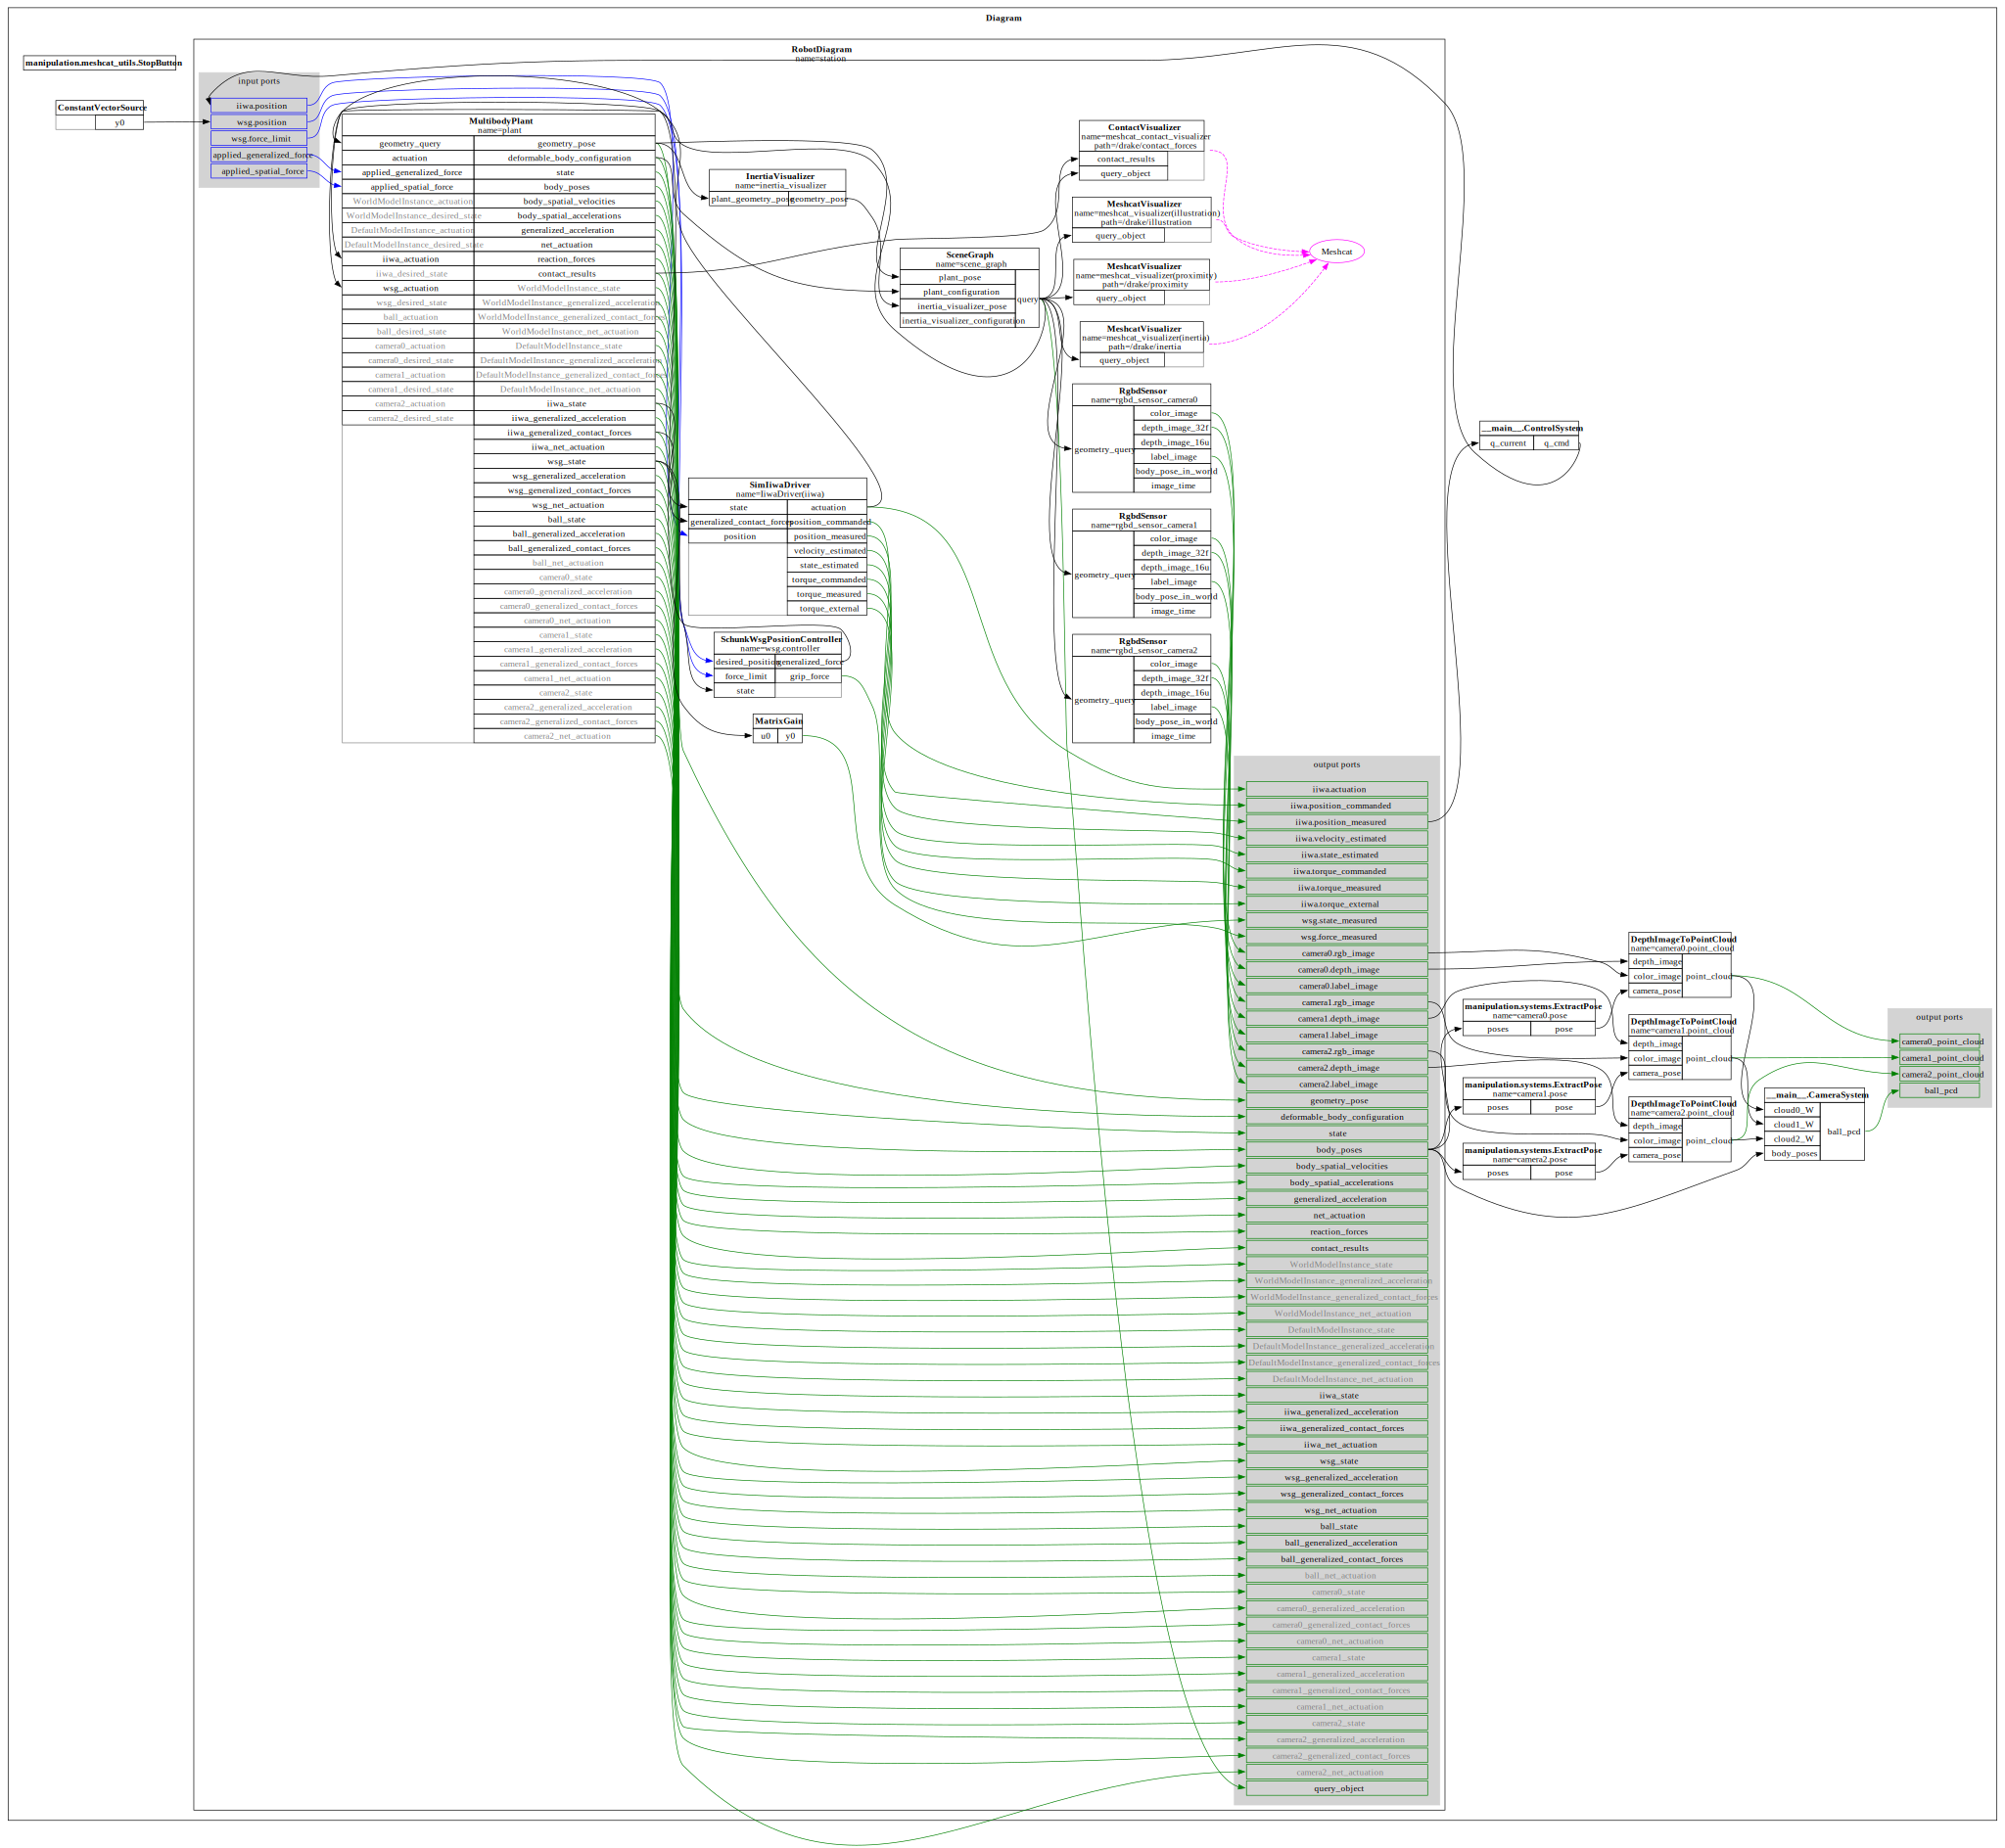

Press Escape to stop the simulation


In [ ]:
env = RoboTossStationSim()

# downsampled_pcd = env.diagram.GetOutputPort("ball_pcd").Eval(env.context_diagram).data
# meshcat.SetObject("masked_cloud", downsampled_pcd, point_size=0.002)


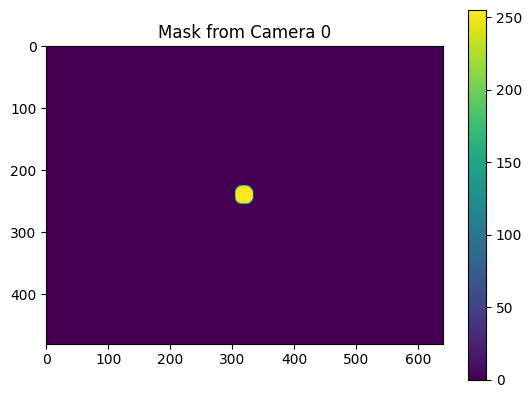

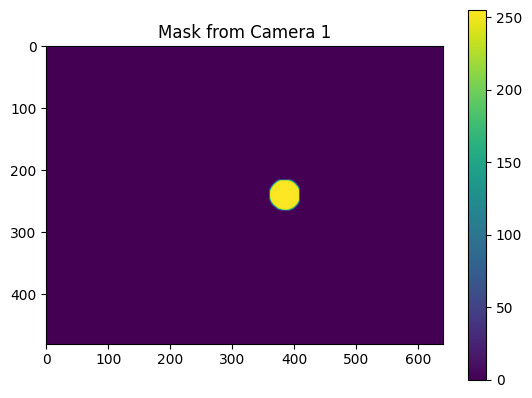

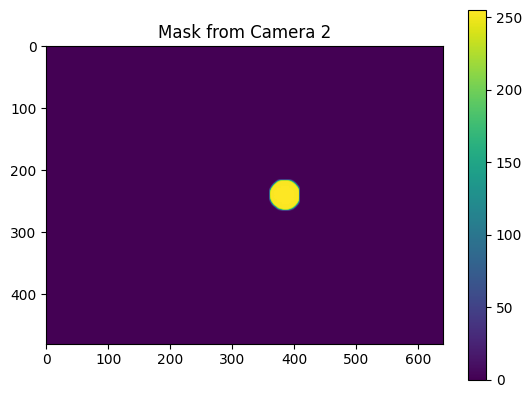

In [ ]:
for i, prediction in enumerate(predictions):
    mask_idx = np.argmax(predictions[i][0]["labels"] == 3)
    mask = predictions[i][0]["masks"][mask_idx, 0]

    plt.imshow(mask)
    plt.title("Mask from Camera " + str(i))
    plt.colorbar()
    plt.show()

In [29]:
class CameraSystemExternal(LeafSystem):
    def __init__(self, num_of_cameras, station):
        LeafSystem.__init__(self)
        rgb_img = AbstractValue.Make(ImageRgba8U())
        depth_img = AbstractValue.Make(ImageDepth32F())
        for i in range(num_of_cameras):
            self.DeclareAbstractInputPort(f"camera{i}_depth_image", depth_img)
            self.DeclareAbstractInputPort(f"camera{i}_rgb_image", rgb_img)
            self.DeclareAbstractInputPort(f"camera{i}_pose", AbstractValue.Make(RigidTransform()))

        ball_pcd_port = self.DeclareAbstractOutputPort(
            "ball_pcd",
            lambda: AbstractValue.Make(PointCloud(0)),
            self.get_merged_masked_pcd,
        )

        self.station = station
        self.num_of_cameras = num_of_cameras
        self.depth_imgs = []
        self.rgb_imgs = []
        self.X_WCs = []
        self.cam_infos = []

    def project_depth_to_pC(self, idx, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        cam_info = self.cam_infos[idx]
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx = cam_info.center_x()
        cy = cam_info.center_y()
        fx = cam_info.focal_x()
        fy = cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

    def read_images(self, cam_context):
        # Read images
        for idx in range(self.num_of_cameras):
            depth_im_read = (
                self.GetInputPort("camera{}_depth_image".format(idx))
                .Eval(cam_context)
                .data.squeeze()
            )
            depth_im = deepcopy(depth_im_read)
            depth_im[depth_im == np.inf] = 10.0
            self.depth_imgs.append(depth_im)
            self.rgb_imgs.append(
                self.GetInputPort("camera{}_rgb_image".format(idx)).Eval(cam_context).data
            )

            # # Visualize
            # point_cloud = diagram.GetOutputPort("camera{}_point_cloud".format(idx)).Eval(
            #     diagram_context
            # )
            # meshcat.SetObject(f"Camera {idx} point cloud", point_cloud)

            # Get other info about the camera
            cam = self.station.GetSubsystemByName("rgbd_sensor_camera" + str(idx))
            self.X_WCs.append(self.GetInputPort("camera{}_pose".format(idx)).Eval(cam_context))
            self.cam_infos.append(cam.default_depth_render_camera().core().intrinsics())

    def predict(self):
        with torch.no_grad():
            predictions = []
            for i in range(self.num_of_cameras):
                predictions.append(
                    model([Tf.to_tensor(self.rgb_imgs[i][:, :, :3]).to(device)])
                )
        for i in range(self.num_of_cameras):
            for k in predictions[i][0].keys():
                if k == "masks":
                    predictions[i][0][k] = (
                        predictions[i][0][k].mul(255).byte().cpu().numpy()
                    )
                else:
                    predictions[i][0][k] = predictions[i][0][k].cpu().numpy()
        return predictions
    
    def get_merged_masked_pcd(self, context, output):
        """
        predictions: The output of the trained network (one for each camera)
        rgb_ims: RGBA images from each camera
        depth_ims: Depth images from each camera
        project_depth_to_pC_funcs: Functions that perform the pinhole camera operations to convert pixels
            into points. See the analogous function in problem 5.2 to see how to use it.
        X_WCs: Poses of the cameras in the world frame
        """
        pcd = []
        self.read_images(context)
        predictions = self.predict()
        i = 0
        for prediction, rgb_im, depth_im, X_WC in zip(
            predictions, self.rgb_imgs, self.depth_imgs, self.X_WCs
        ):
            mask_idx = np.argmax(prediction[0]["labels"] == BALL_IDX)
            prediction_mask = prediction[0]["masks"][mask_idx, 0] > 250 # mask_threshold

            non_zero_idx = np.array(list(zip(*np.nonzero(prediction_mask))))
            num_of_masked_points = np.sum(prediction_mask)

            depth = depth_im[prediction_mask].reshape(-1, 1)
            depth_pixels = np.concatenate((non_zero_idx, depth), axis=1)
            
            spatial_points = self.project_depth_to_pC(i, depth_pixels).T
            spatial_points = X_WC @ spatial_points
            rgb_points = rgb_im[prediction_mask, :-1].T

            # You get an unhelpful RunTime error if your arrays are the wrong
            # shape, so we'll check beforehand that they're the correct shapes.
            assert (
                len(spatial_points.shape) == 2
            ), "Spatial points is the wrong size -- should be 3 x N"
            assert (
                spatial_points.shape[0] == 3
            ), "Spatial points is the wrong size -- should be 3 x N"
            assert (
                len(rgb_points.shape) == 2
            ), "RGB points is the wrong size -- should be 3 x N"
            assert (
                rgb_points.shape[0] == 3
            ), "RGB points is the wrong size -- should be 3 x N"
            assert rgb_points.shape[1] == spatial_points.shape[1]

            N = spatial_points.shape[1]
            pcd.append(PointCloud(N, Fields(BaseField.kXYZs | BaseField.kRGBs)))
            pcd[-1].mutable_xyzs()[:] = spatial_points
            pcd[-1].mutable_rgbs()[:] = rgb_points
            # Estimate normals
            pcd[-1].EstimateNormals(radius=0.1, num_closest=30)
            # Flip normals toward camera
            pcd[-1].FlipNormalsTowardPoint(X_WC.translation())
            i += 1

        # Merge point clouds.
        merged_pcd = Concatenate(pcd)
        # Voxelize down-sample.  (Note that the normals still look reasonable)
        downsampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)
        print(downsampled_pcd)
        # Visualize
        
        output.set_value(downsampled_pcd)

In [30]:
class ControlSystemExt(LeafSystem):
    def __init__(self, interactive, q_cmd):
        LeafSystem.__init__(self)

        self._interactive = interactive
        self._q_cmd = q_cmd

        # Declare input and output ports.
        self._q_current_input = self.DeclareVectorInputPort(name="q_current", size=7)
        self.DeclareVectorOutputPort(name="q_cmd", size=7, calc=self.CalcOutput)

    def CalcOutput(self, context, output):
        # Read the input port.
        q_current = self._q_current_input.Eval(context)

        if self._interactive and running_as_notebook and self._q_cmd is None:
            q_cmd = q_current.copy()

            for i in range(7):
                q_cmd[i] = float(
                input(
                    f"Please enter value for {i}th movable joint (current value: {q_current[i]:.3f})"
                )
            )
            self._q_cmd = q_cmd
        else:
            q_cmd = self._q_cmd

        if q_cmd is None:
            q_cmd = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

        # Write to the output port.
        output.SetFromVector(q_cmd)

    def reset(self):
        self._q_cmd = None

In [169]:
class RoboTossStationSimExt:
    def __init__(self):
        builder = DiagramBuilder()
        scenario = LoadScenario(filename="models/pingpong.scenario.yaml")
        self.station = builder.AddSystem(
            MakeHardwareStation(scenario, meshcat=meshcat,
                                package_xmls=["./package.xml"])
        )
        self.plant = self.station.GetSubsystemByName("plant")
        self.scene_graph = self.station.GetSubsystemByName("scene_graph")
        self.query_output_port = self.scene_graph.GetOutputPort("query")

        # Add system to extract camera poses
        self.extract_pose = AddExtractPose(scenario=scenario, station=self.station, builder=builder)

        # Add point cloud processing system
        self.num_of_cameras = 3
        self.camera_system = builder.AddSystem(CameraSystemExternal(self.num_of_cameras, self.station))
        for i in range(self.num_of_cameras):
            builder.Connect(
                self.station.GetOutputPort(f"camera{i}.depth_image"),
                self.camera_system.GetInputPort(f"camera{i}_depth_image"),
            )
            builder.Connect(
                self.station.GetOutputPort(f"camera{i}.rgb_image"),
                self.camera_system.GetInputPort(f"camera{i}_rgb_image"),
            )
            extract_pose = self.extract_pose[f"camera{i}"]
            builder.Connect(
                extract_pose.GetOutputPort("pose"),
                self.camera_system.GetInputPort(f"camera{i}_pose"),
            )
        builder.ExportOutput(
            self.camera_system.GetOutputPort("ball_pcd"),
            "ball_pcd",
        )
        
        # Add Grasp Selector
        # self.grasph_selector = builder.AddSystem(GraspSelector(xxx))
        
        # Add controller to iiwa joint inputs
        command_input_system = builder.AddSystem(ControlSystemExt(False, None))
        builder.Connect(
            command_input_system.GetOutputPort("q_cmd"),
            self.station.GetInputPort("iiwa.position"),
        )
        builder.Connect(
            self.station.GetOutputPort("iiwa.position_measured"),
            command_input_system.GetInputPort("q_current"),
        )

        # Add controller to wsg inputs
        wsg_position = builder.AddSystem(ConstantVectorSource([0.06]))
        builder.Connect(
            wsg_position.get_output_port(), self.station.GetInputPort("wsg.position")
        )

        # Add stop button
        builder.AddSystem(StopButton(meshcat))
        self.diagram = builder.Build()

        # Store contexts
        self.context_diagram = self.diagram.CreateDefaultContext()
        self.context_station = self.diagram.GetSubsystemContext(
            self.station, self.context_diagram
        )
        self.context_scene_graph = self.station.GetSubsystemContext(
            self.scene_graph, self.context_station
        )
        self.context_plant = self.station.GetMutableSubsystemContext(
            self.plant, self.context_station
        )
        
        # Set initial position of the ball and the cup
        ball_instance = self.plant.GetModelInstanceByName("ball")
        ball_body = self.plant.GetBodyByName("ball", ball_instance)
        self.plant.SetFreeBodyPose(self.context_plant, ball_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, 0.5, 0.7325]))

        cup_instance = self.plant.GetModelInstanceByName("cup")
        cup_body = self.plant.GetBodyByName("cup", cup_instance)
        self.plant.SetFreeBodyPose(self.context_plant, cup_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, -0.5, 0.7325]))

        # import pydot
        # from IPython.display import SVG, display

        # display(SVG(pydot.graph_from_dot_data(
        #     self.diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
        
        simulator = Simulator(self.diagram, self.context_diagram)
        meshcat.StartRecording()
        simulator.AdvanceTo(3 if running_as_notebook else 0.1)
        meshcat.PublishRecording()

In [107]:
class CameraSystemExt:
    def __init__(self, idx, meshcat, station, diagram, context, root_context):
        self.idx = idx

        # Read images
        depth_im_read = (
            station.GetOutputPort("camera{}.depth_image".format(idx))
            .Eval(context)
            .data.squeeze()
        )
        self.depth_im = deepcopy(depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        self.rgb_im = (
            station.GetOutputPort("camera{}.rgb_image".format(idx)).Eval(context).data
        )

        # Visualize
        # point_cloud = diagram.GetOutputPort("camera{}_point_cloud".format(idx)).Eval(
        #     root_context
        # )
        # meshcat.SetObject(f"Camera {idx} point cloud", point_cloud)

        # Get other info about the camera
        cam = station.GetSubsystemByName("rgbd_sensor_camera" + str(idx))
        cam_context = cam.GetMyMutableContextFromRoot(root_context)
        self.X_WC = cam.body_pose_in_world_output_port().Eval(cam_context)
        self.cam_info = cam.default_depth_render_camera().core().intrinsics()

    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

Failed to load material file(s). Use default material.



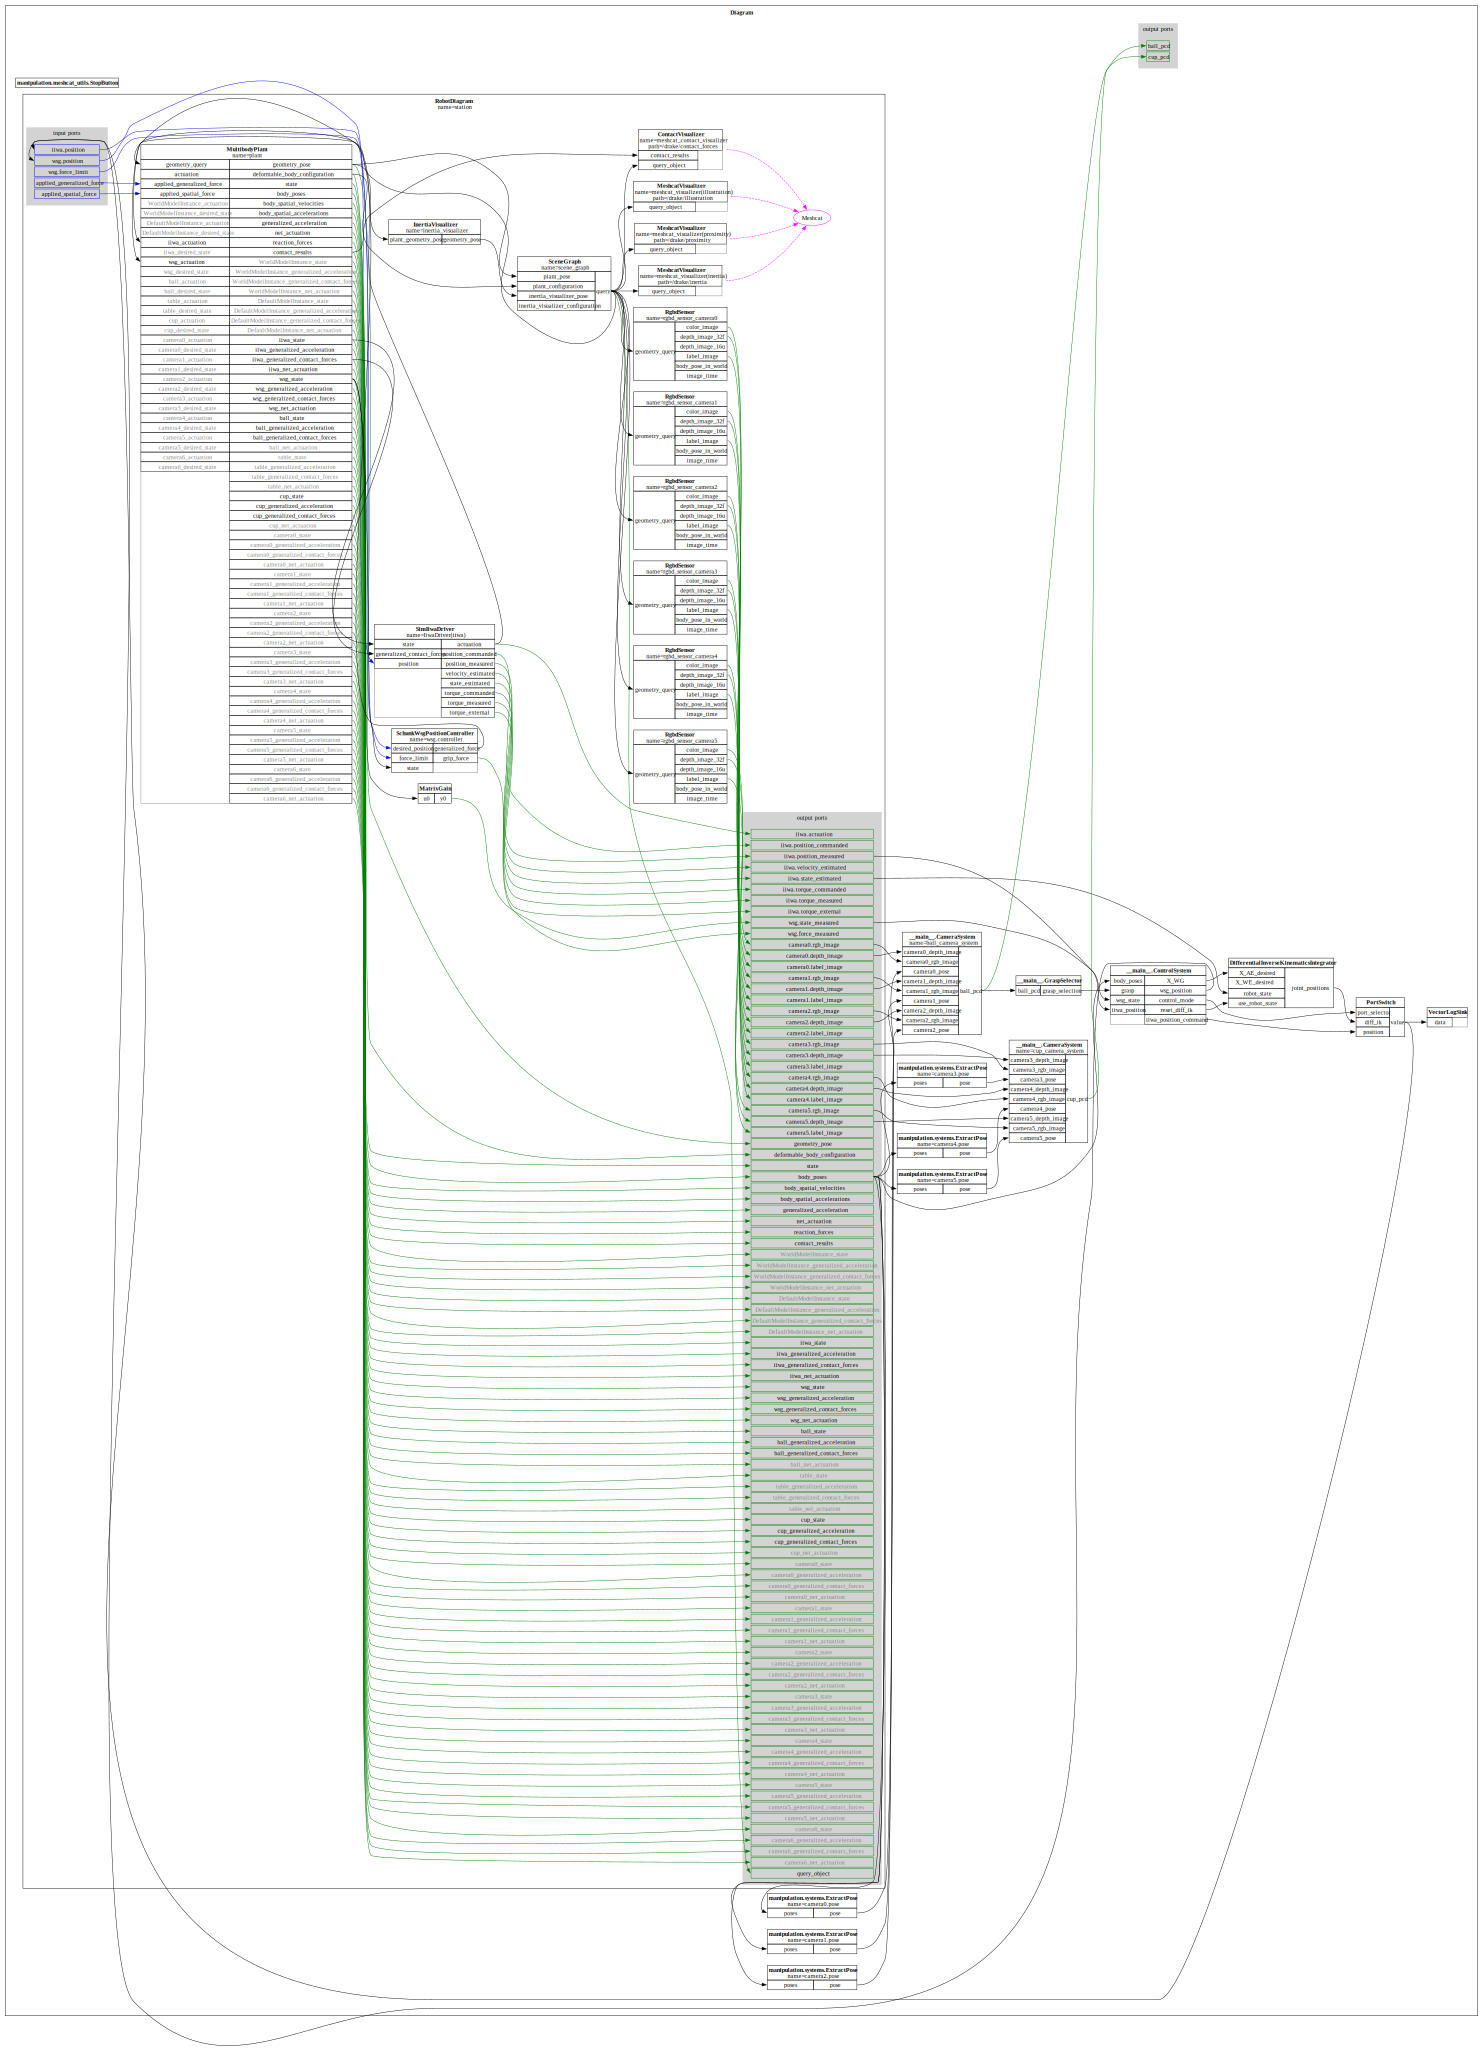

Press Escape to stop the simulation


RuntimeError: System cup_camera_system does not have an input port named camera0_depth_image (valid port names: camera3_depth_image, camera3_rgb_image, camera3_pose, camera4_depth_image, camera4_rgb_image, camera4_pose, camera5_depth_image, camera5_rgb_image, camera5_pose)

In [180]:
meshcat.Delete()
env = RoboTossStationSim()
cameras = []
for i in range(6):
    cameras.append(CameraSystemExt(i, meshcat, env.station, env.diagram, env.context_station, env.context_diagram))

downsampled_pcd = env.diagram.GetOutputPort("cup_pcd").Eval(env.context_diagram)
meshcat.SetObject("masked_cloud", downsampled_pcd, point_size=0.002)

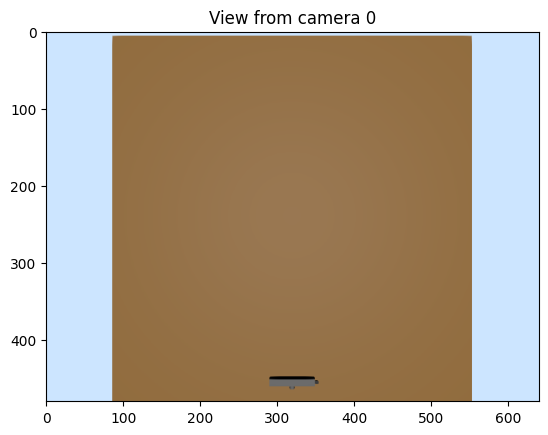

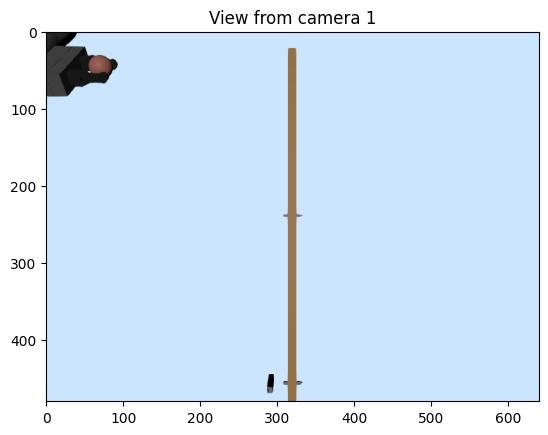

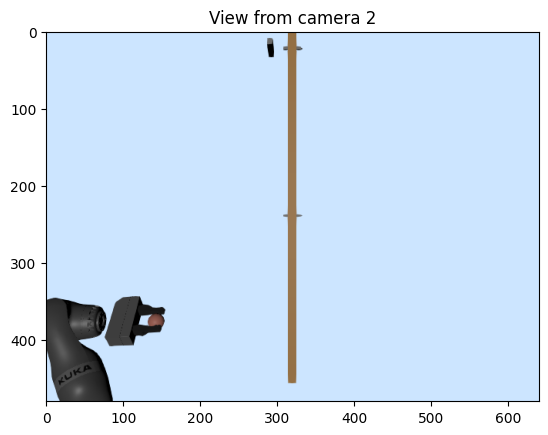

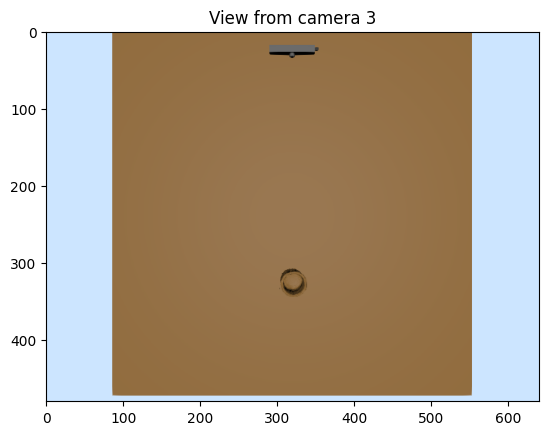

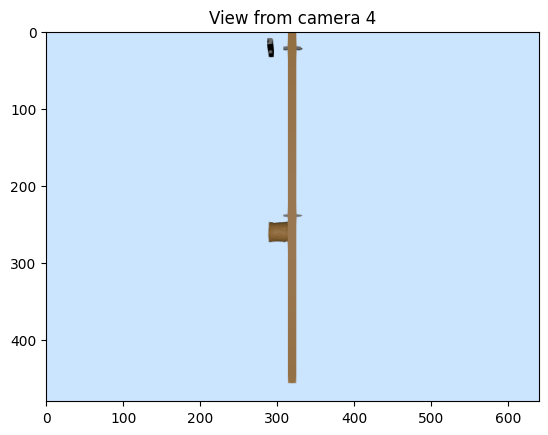

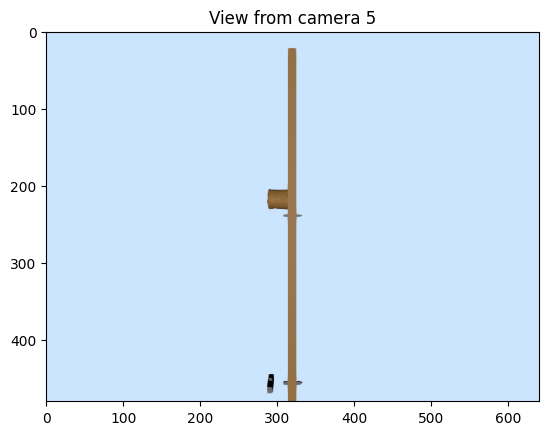

In [174]:
for i in range(6):
    plt.imshow(cameras[i].rgb_im)
    plt.title(f"View from camera {i}")
    plt.show()

In [ ]:
env = RoboTossStationSim()
cameras = []

for i in range(3):
    cameras.append(CameraSystem(i, meshcat, env.station, env.diagram, env.context_station, env.context_diagram))

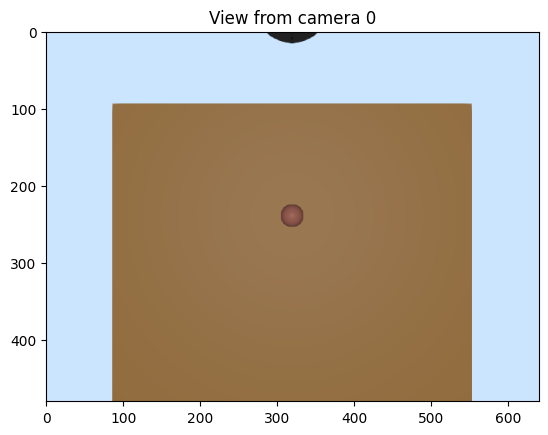

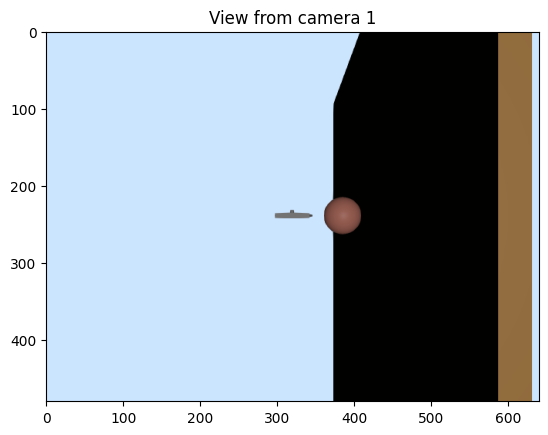

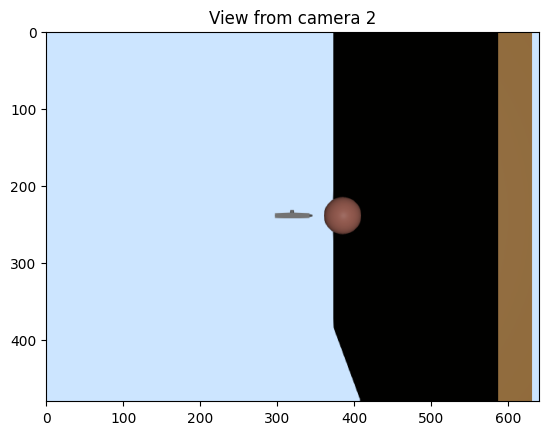

In [ ]:
for i in range(3):
    plt.imshow(cameras[i].rgb_im)
    plt.title(f"View from camera {i}")
    plt.show()

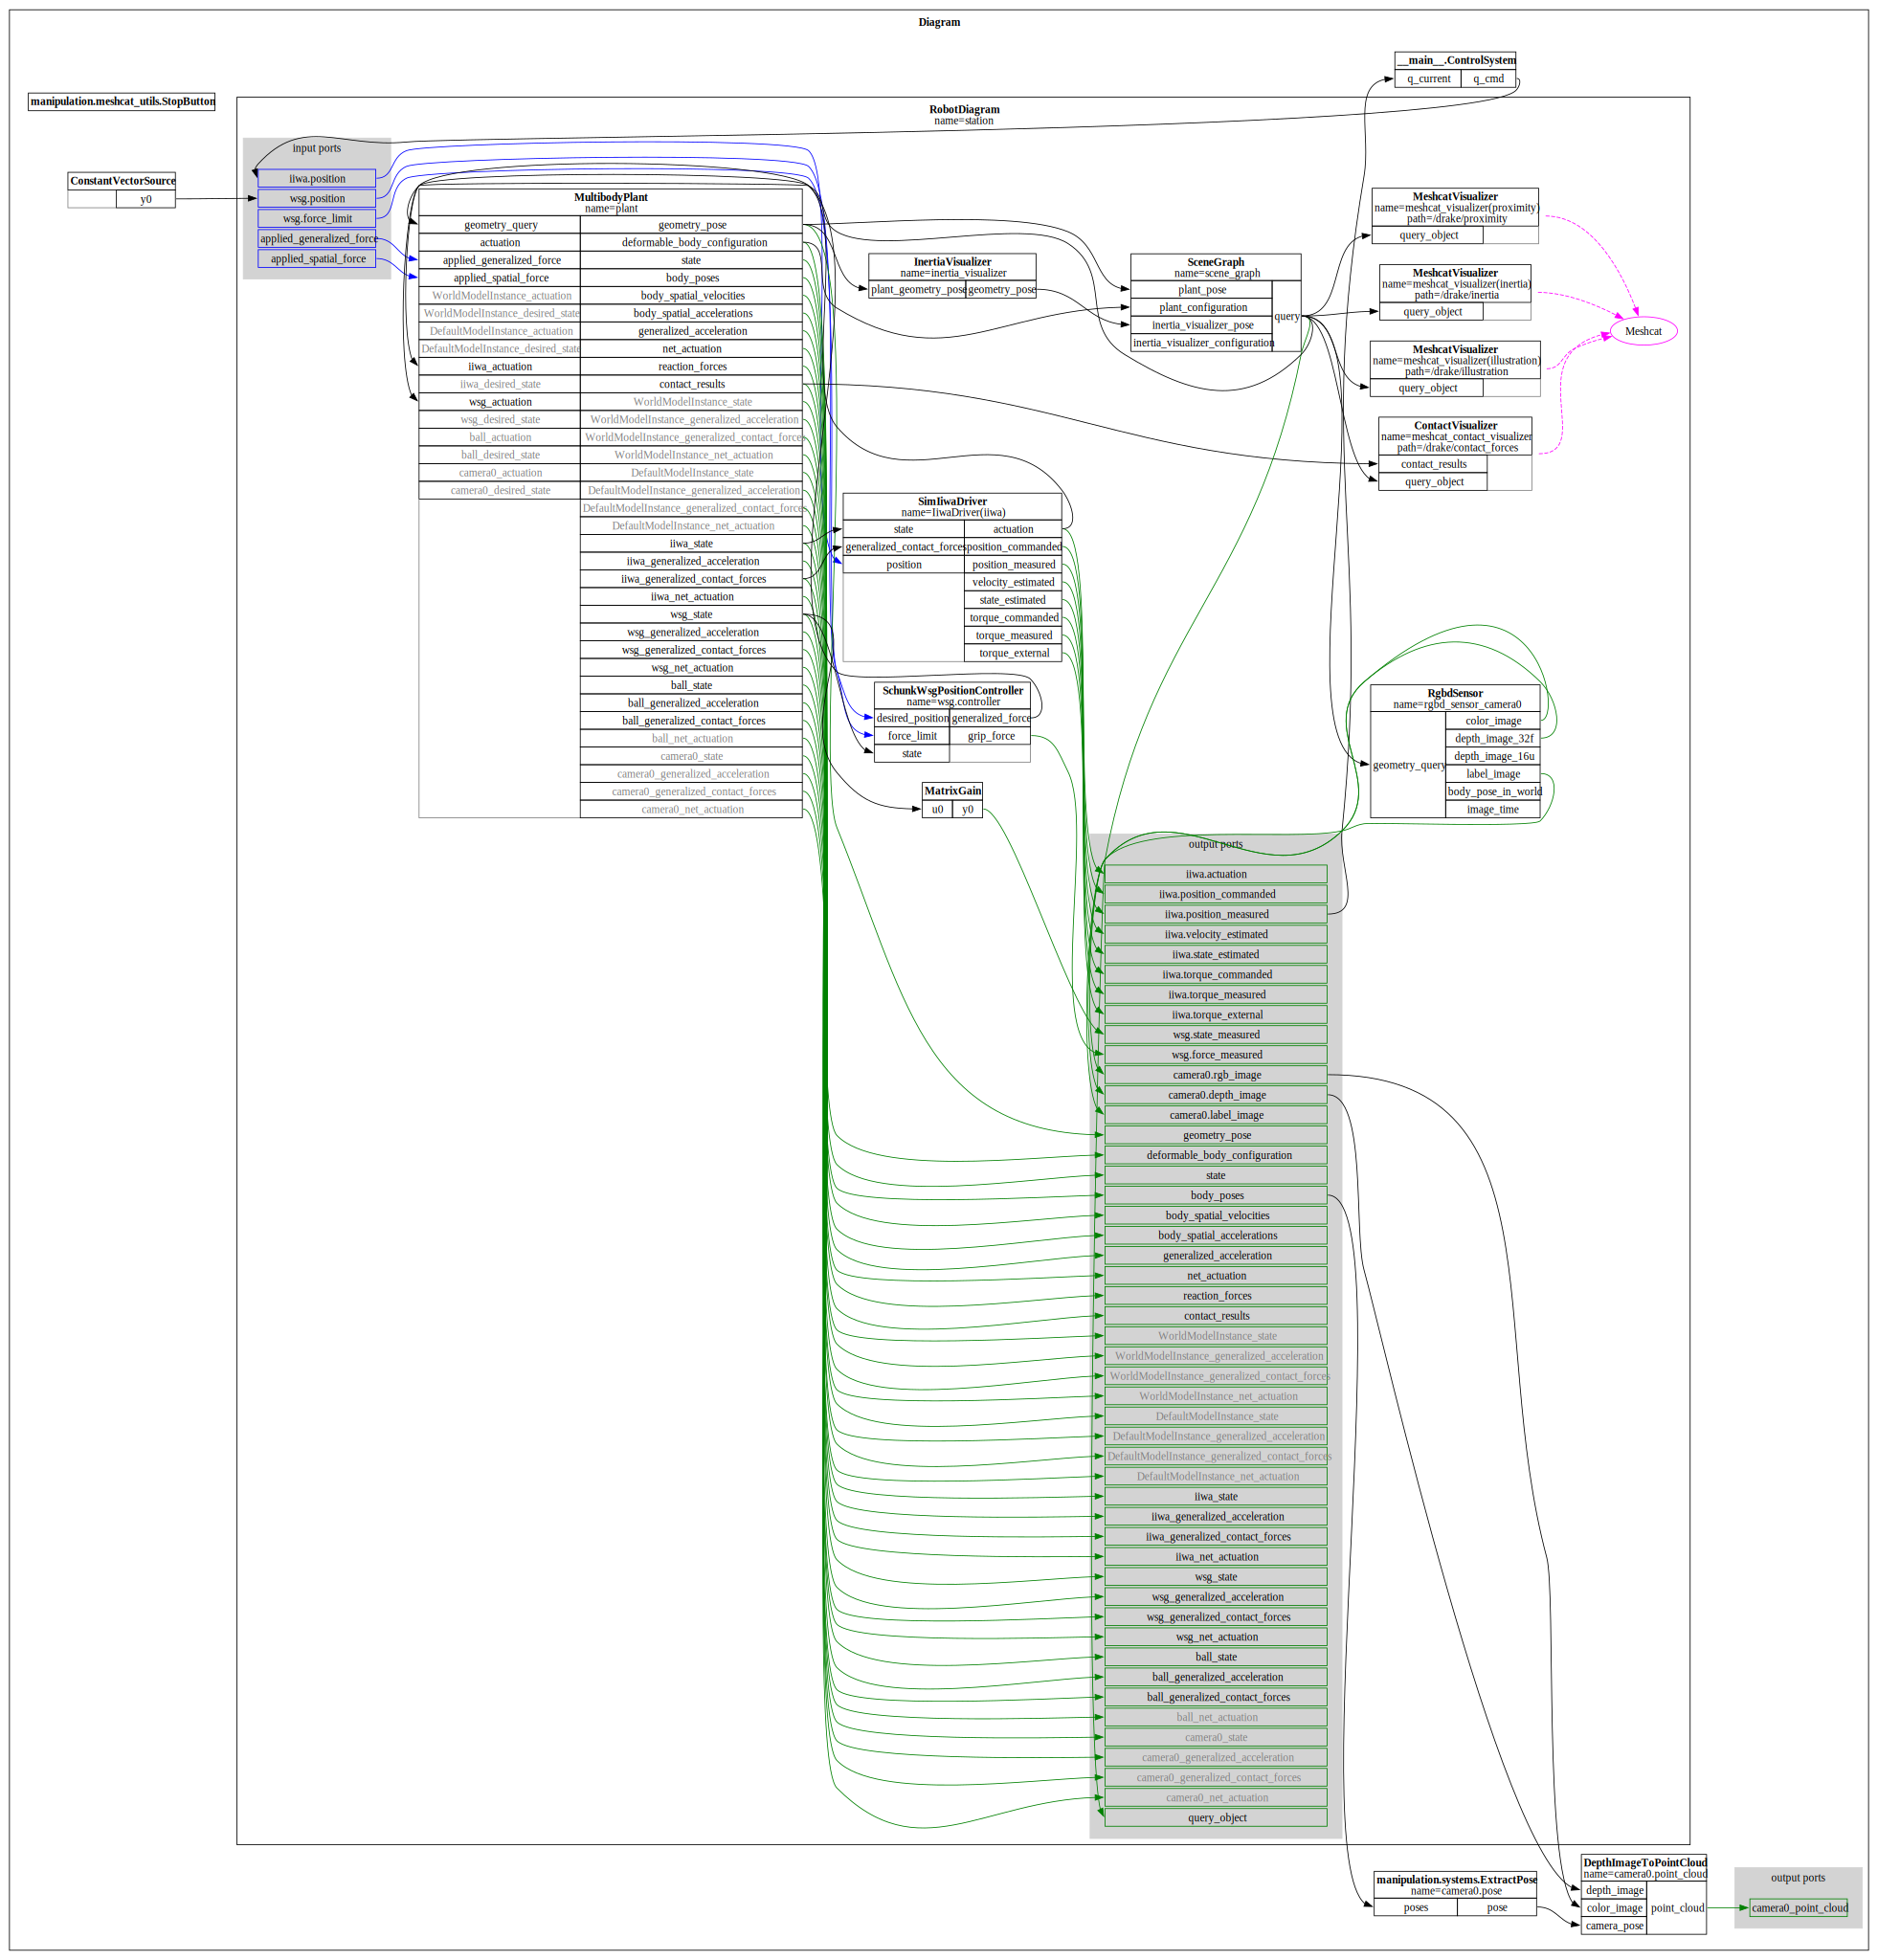

Press Escape to stop the simulation


In [ ]:
env = RoboTossStationSim()

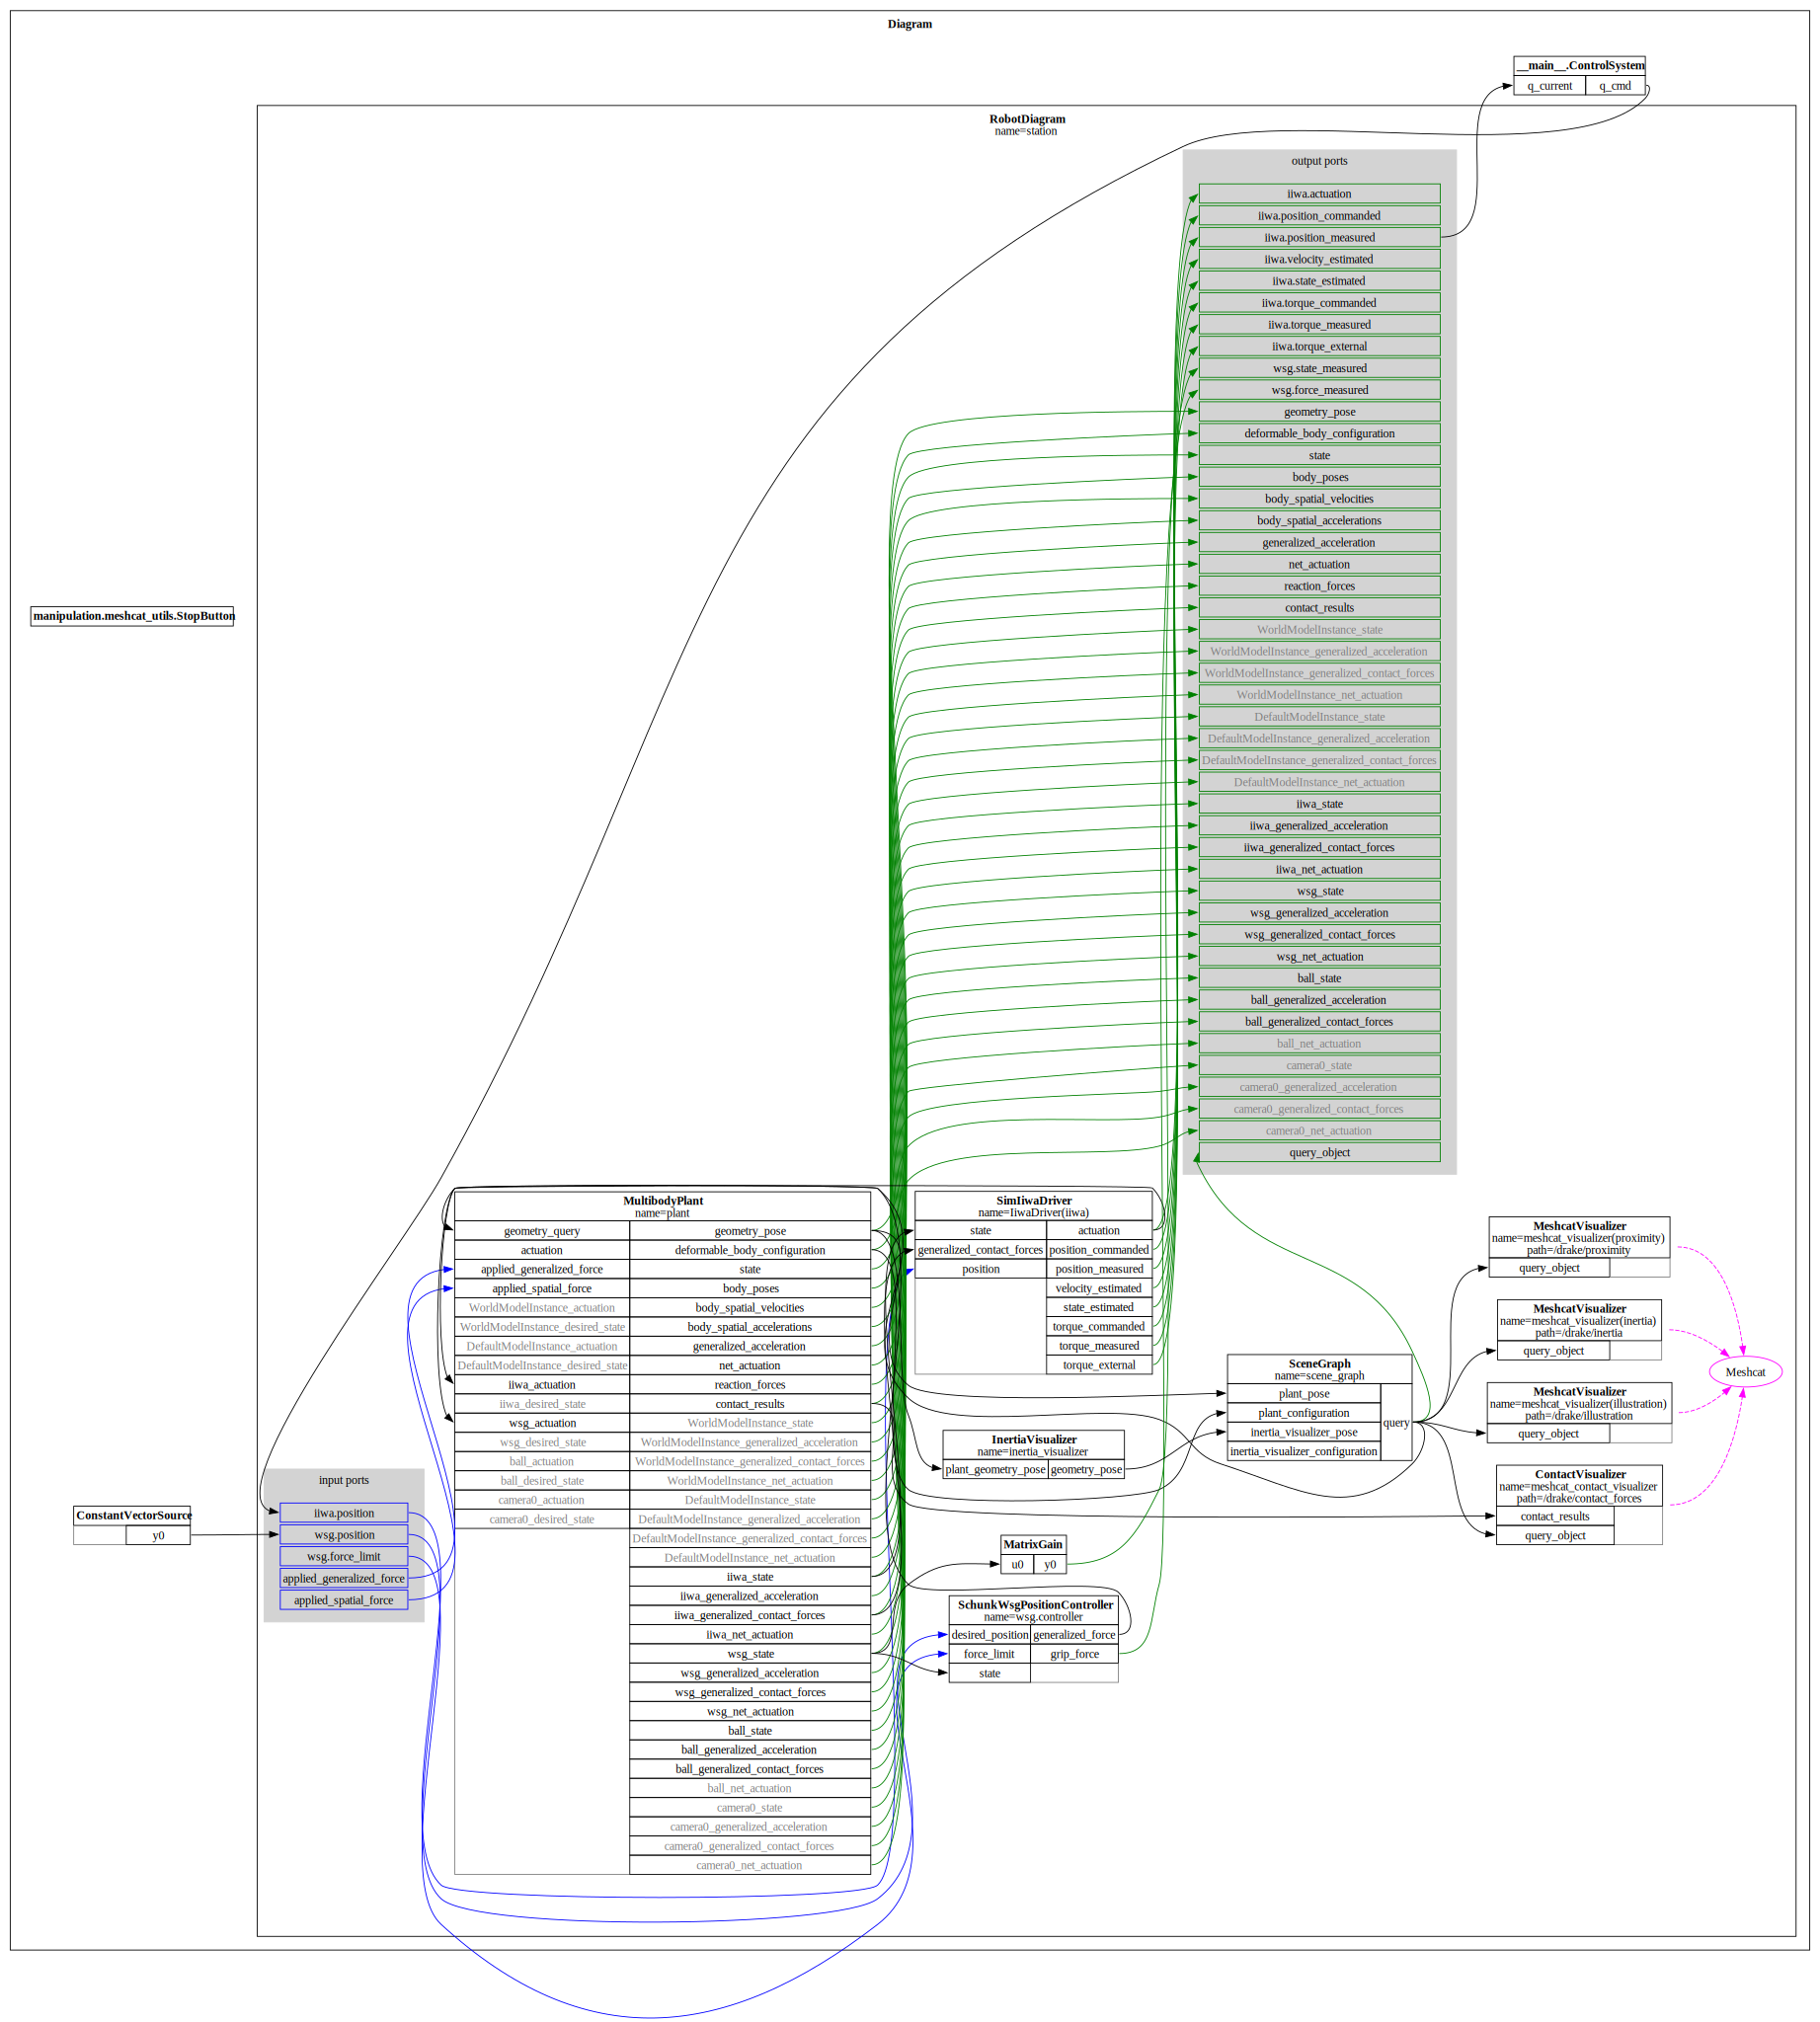

Press Escape to stop the simulation


In [ ]:
env = RoboTossStationSim()

In [109]:
def ball_drop(stiffness, dissipation):
  builder = DiagramBuilder()
  time_step = 0.001
  plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step)
  Parser(plant).AddModels("./models/ball.sdf")
  plant.Finalize()

  visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

  diagram = builder.Build()
  simulator = Simulator(diagram)

  context = simulator.get_mutable_context()
  plant_context = plant.GetMyMutableContextFromRoot(context)

  ball_instance = plant.GetModelInstanceByName("bouncing_ball")
  ball_body = plant.GetBodyByName("ball", ball_instance)
  plant.SetFreeBodyPose(plant_context, ball_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, 0.5, 0.7325]))

  # import pydot
  # from IPython.display import SVG, display

  # display(SVG(pydot.graph_from_dot_data(
  #     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

  visualizer.StartRecording()
  simulator.AdvanceTo(3 if running_as_notebook else 0.1)
  visualizer.PublishRecording()


# These are the default values that MultibodyPlant picked (on Nov 16, 2022) for
# this system.
ball_drop(stiffness=20000, dissipation=0.1)